In [55]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib


In [56]:
#Load data
DATA_PATH = "heart.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [57]:
#missing values before handling
print(df.info())
print("\nMissing values (before):")
display(df.isnull().sum().sort_values(ascending=False).head(30))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Missing values (before):


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [58]:
#  Check numeric columns ---
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print("🔢 Numeric columns:", numeric_cols)

# Display outlier count
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)
print(outlier_df)


🔢 Numeric columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
              Outlier Count
FastingBS               214
Cholesterol             183
RestingBP                28
Oldpeak                  16
MaxHR                     2
Age                       0
HeartDisease              0


In [59]:
# Detect outliers using IQR method
print("\n🔍 Checking for outliers using IQR method...\n")
outlier_summary = {}

for col in numeric_cols:
    if col != 'heartdisease':  # exclude target variable
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_summary[col] = outliers



🔍 Checking for outliers using IQR method...



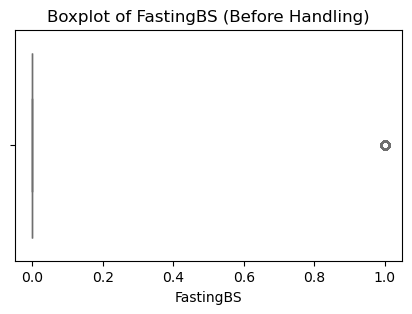

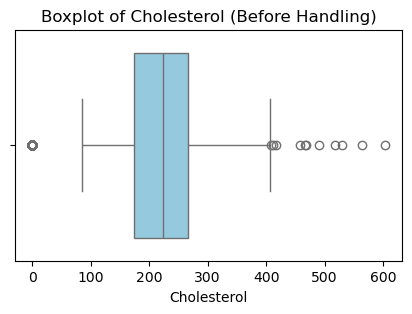

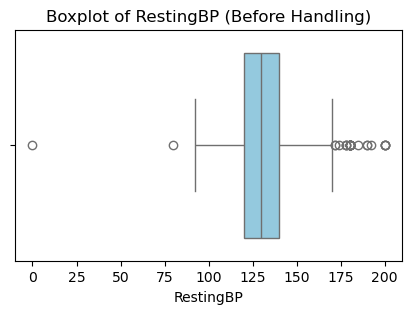

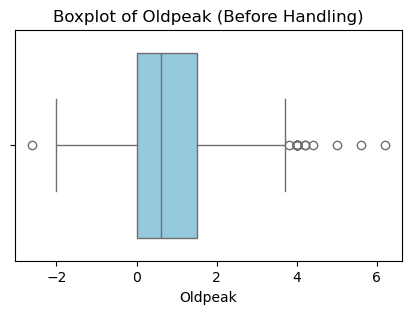

In [60]:
# Visualize outliers (boxplots for top 4 columns)
top_cols = outlier_df.head(4).index.tolist()
for col in top_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot of {col} (Before Handling)")
    plt.show()

In [62]:
# Handle outliers using IQR capping
for col in numeric_cols:
    if col != 'heartdisease':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))

print("\n Outliers handled successfully using IQR capping!")


 Outliers handled successfully using IQR capping!


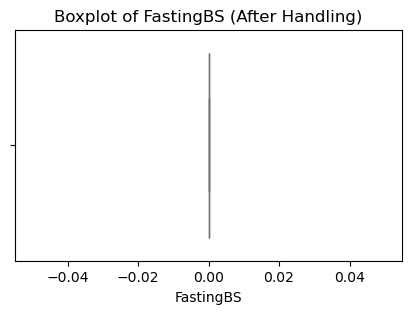

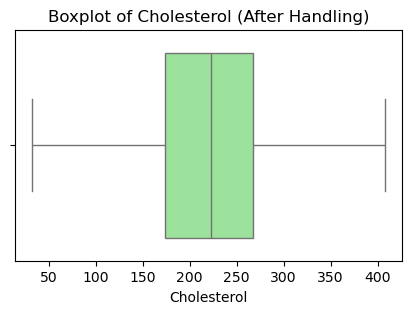

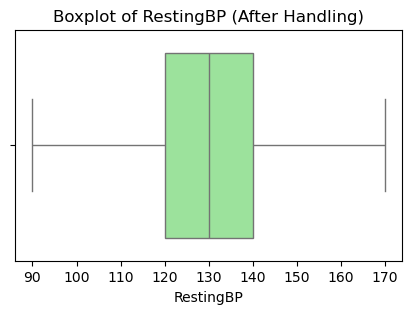

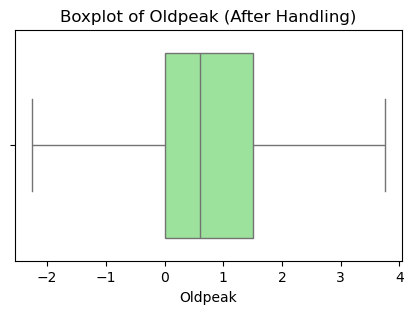

In [63]:
# Verify after handling
for col in top_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col} (After Handling)")
    plt.show()

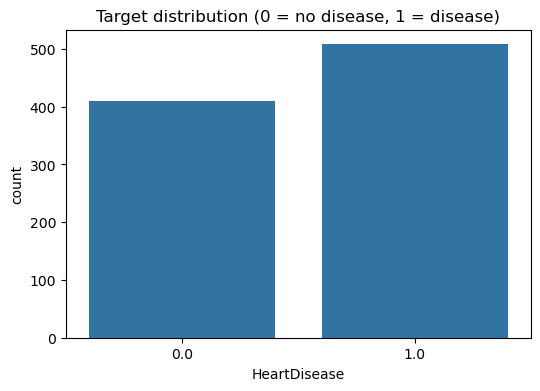

In [64]:
#EDA - target balance
TARGET = "HeartDisease" 

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df[TARGET])
plt.title("Target distribution (0 = no disease, 1 = disease)")
plt.show()


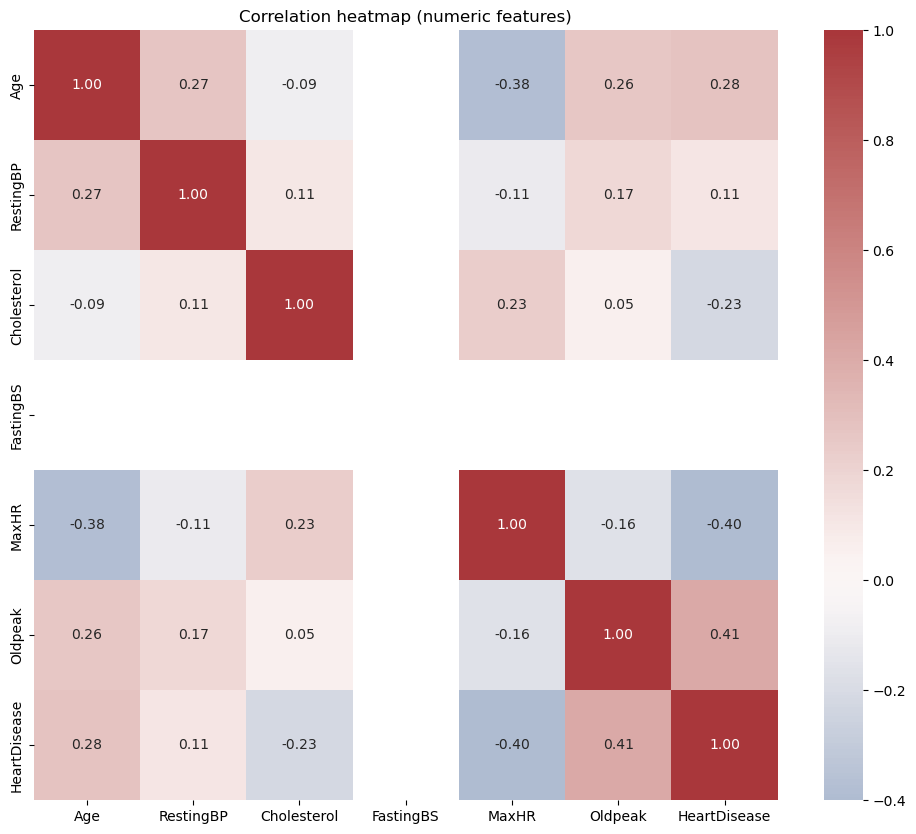

In [65]:
# Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()


In [66]:
#  X and target y
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int) 

# Identify column types for preprocessing
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [67]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (734, 11) Test shape: (184, 11)


In [68]:
#Preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")


In [69]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    "SVM": SVC(random_state=RANDOM_STATE, probability=True),
    "KNN": KNeighborsClassifier()
}

# Create pipelines for each model
pipelines = {name: Pipeline(steps=[("preprocessor", preprocessor), ("classifier", clf)]) for name, clf in models.items()}


In [70]:
# Train, predict and evaluate on test set; also collect cross-validated F1
metrics_list = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, pipe in pipelines.items():
    print(f"\nTraining: {name}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # cross-validated F1 on training data for robustness
    cv_f1 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    metrics_list.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cv_f1_mean": cv_f1
    })
    
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | CV mean F1: {cv_f1:.4f}")



Training: LogisticRegression
Accuracy: 0.8804 | Precision: 0.8704 | Recall: 0.9216 | F1: 0.8952 | CV mean F1: 0.8666

Training: DecisionTree
Accuracy: 0.7826 | Precision: 0.8039 | Recall: 0.8039 | F1: 0.8039 | CV mean F1: 0.8256

Training: RandomForest
Accuracy: 0.8967 | Precision: 0.8952 | Recall: 0.9216 | F1: 0.9082 | CV mean F1: 0.8802

Training: SVM
Accuracy: 0.8967 | Precision: 0.8807 | Recall: 0.9412 | F1: 0.9100 | CV mean F1: 0.8775

Training: KNN
Accuracy: 0.9022 | Precision: 0.9038 | Recall: 0.9216 | F1: 0.9126 | CV mean F1: 0.8706


In [71]:
#Aggregate metrics into DataFrame and sort by chosen metric (F1)
metrics_df = pd.DataFrame(metrics_list).sort_values(by="f1", ascending=False).reset_index(drop=True)
metrics_df


,model,accuracy,precision,recall,f1,cv_f1_mean
0,KNN,0.902174,0.903846,0.921569,0.912621,0.870591
1,SVM,0.896739,0.880734,0.941176,0.909953,0.877543
2,RandomForest,0.896739,0.895238,0.921569,0.908213,0.880182
3,LogisticRegression,0.880435,0.870370,0.921569,0.895238,0.866565
4,DecisionTree,0.782609,0.803922,0.803922,0.803922,0.825596


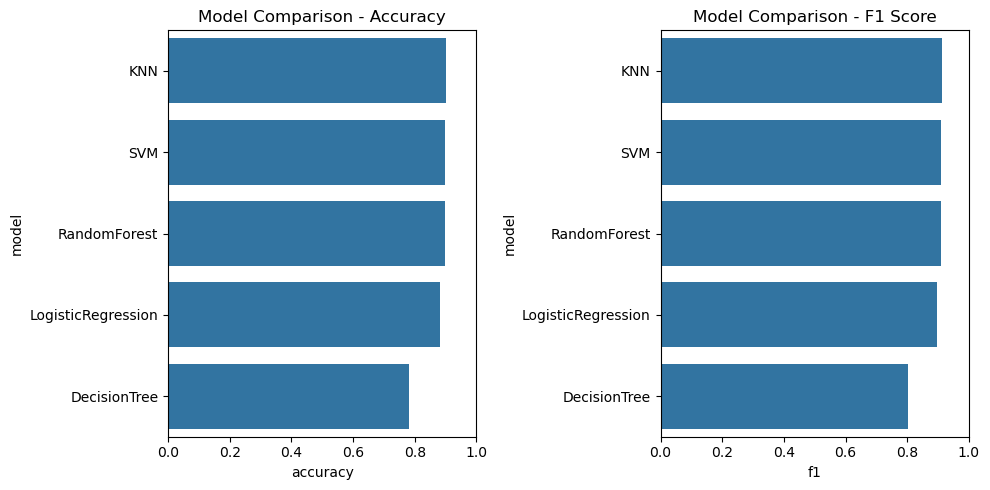

In [72]:
# Plot model comparison (Accuracy and F1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x="accuracy", y="model", data=metrics_df, orient="h")
plt.title("Model Comparison - Accuracy")
plt.xlim(0,1)

plt.subplot(1,2,2)
sns.barplot(x="f1", y="model", data=metrics_df, orient="h")
plt.title("Model Comparison - F1 Score")
plt.xlim(0,1)

plt.tight_layout()
plt.show()


Best model by F1: KNN

Classification Report (best model):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



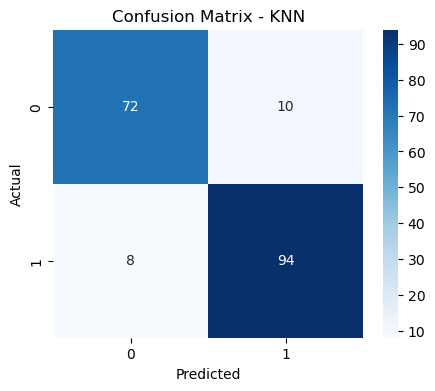

In [73]:
# Identify best model (by F1) and show confusion matrix + classification report
best_row = metrics_df.iloc[0]
best_model_name = best_row["model"]
print("Best model by F1:", best_model_name)
best_pipeline = pipelines[best_model_name]

# Evaluate best pipeline on test set
y_pred_best = best_pipeline.predict(X_test)
print("\nClassification Report (best model):")
print(classification_report(y_test, y_pred_best, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [74]:
import pickle

# Save the trained best model pipeline
with open("heart_best_model_KNN.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print("✅ heart_best_model_KNN.pkl saved successfully!")


✅ heart_best_model_KNN.pkl saved successfully!


In [75]:
test_model = pickle.load(open("heart_best_model_KNN.pkl", "rb"))
print("✅ Model loaded successfully!")


✅ Model loaded successfully!
